In [1]:
import nltk
from nltk.corpus import brown

nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [2]:
corpus = brown.tagged_sents(tagset='universal')

In [3]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [4]:
len(corpus)

57340

In [5]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
  tokens = []
  target = []

  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Bidirectional
from keras.layers import LSTM, GRU, SimpleRNN, Embedding
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy

In [7]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs,targets,test_size=0.3)

In [8]:
# Convert  sentence to sequences
MAX_VOCAB_SIZE = None

should_lowercase = False
word_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,lower=should_lowercase,oov_token='UNK',)

# we do not Want remove the unknown words because if we do this the len(inputs) != len(targets)

In [9]:
word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [10]:
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens. ' % V )

Found 47475 unique tokens. 


In [11]:
def flattern(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [12]:
all_train_targets = set(flattern(train_targets))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [13]:
all_test_targets = set(flattern(test_targets))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [14]:
all_train_targets == all_test_targets

True

In [15]:
# Convert targets to sequneces

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

In [16]:
# save for later

train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [17]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets

maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train,maxlen_test))


In [18]:
# Pad sequences so that we get a N X T matrix
train_inputs_int = pad_sequences(train_inputs_int,maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (40138, 180)


In [19]:
test_inputs_int = pad_sequences(test_inputs_int,maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (17202, 180)


In [20]:
train_targets_int = pad_sequences(train_targets_int,maxlen=T)
print('Shape of data train tensor:', train_targets_int.shape)

Shape of data train tensor: (40138, 180)


In [21]:
test_targets_int = pad_sequences(test_targets_int,maxlen=T)
print('Shape of data test tensor:', test_targets_int.shape)

Shape of data test tensor: (17202, 180)


In [22]:
# number of classes

K = len(tag_tokenizer.word_index) + 1
K

13

In [23]:
# create the model

# we get to chosse embedding dimensionality
D = 32

i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i,x)

# compile and fit

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics = ['accuracy'])

# fit the model
print('Training model...')
model.fit(train_inputs_int,
          train_targets_int,
          epochs=5,
          validation_data=(test_inputs_int,test_targets_int))


Training model...
Epoch 1/5
1255/1255 [==============================] - 980s 771ms/step - loss: 0.4795 - accuracy: 0.8547 - val_loss: 0.1118 - val_accuracy: 0.9653
Epoch 2/5
1255/1255 [==============================] - 1046s 833ms/step - loss: 0.0736 - accuracy: 0.9773 - val_loss: 0.0864 - val_accuracy: 0.9718
Epoch 3/5
1255/1255 [==============================] - 940s 749ms/step - loss: 0.0458 - accuracy: 0.9857 - val_loss: 0.0840 - val_accuracy: 0.9727
Epoch 4/5
1255/1255 [==============================] - 925s 737ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.0853 - val_accuracy: 0.9736
Epoch 5/5
1255/1255 [==============================] - 940s 749ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.0901 - val_accuracy: 0.9731


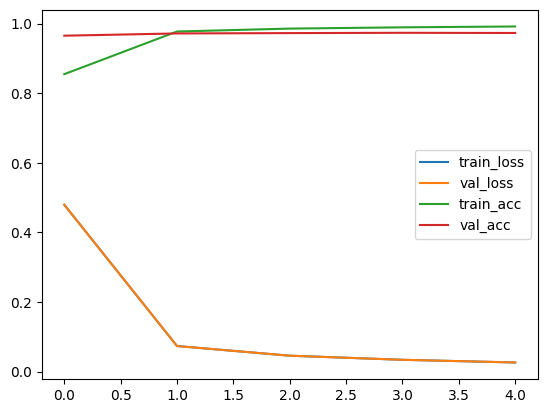

In [24]:
#plot loss per iteration
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['loss'], label='val_loss')
plt.legend();

plt.plot(model.history.history['accuracy'], label='train_acc')
plt.plot(model.history.history['val_accuracy'], label='val_acc')
plt.legend();

In [25]:
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

train_probs = model.predict(train_inputs_int)
train_predictions = []

for probs, length in zip(train_probs, train_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

1255/1255 [==============================] - 120s 93ms/step


In [31]:
# Flatten
flat_train_predictions = flattern(train_predictions)
flat_train_targets = flattern(train_targets_int_unpadded)

In [27]:
test_probs = model.predict(test_inputs_int)
test_predictions = []

for probs, length in zip(test_probs, test_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

538/538 [==============================] - 66s 122ms/step


In [32]:
flat_test_predictions = flattern(test_predictions)
flat_test_targets = flattern(test_targets_int_unpadded)

In [33]:
from sklearn.metrics import accuracy_score, f1_score

print('Train ACC: ', accuracy_score(flat_train_targets, flat_train_predictions))
print('test ACC: ', accuracy_score(flat_test_targets, flat_test_predictions))

print('Train f1', f1_score(flat_train_targets,flat_train_predictions, average='macro'))
print('Test f1', f1_score(flat_test_targets,flat_test_predictions, average='macro'))

Train ACC:  0.9941205448016698
test ACC:  0.9730680269953423
Train f1 0.9873361734164825
Test f1 0.9295158233947133


In [34]:
from collections import  Counter

def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [35]:
token2tags = {K: [] for k, v in word2idx.items()}


In [37]:
token2tags

{13: []}

In [36]:
# remove UNK token

del token2tags['UNK']


KeyError: 'UNK'